# Running Scenarios with Mantis
## Start Mantis Server
* Download the Tule River data

First, download the Tule River data from the **Mantis Data repository**:\
Kourakos, G. (2025). Data for Mantis code, HydroShare, http://www.hydroshare.org/resource/67baab0cf1ec4e5b9eafe95f917fdf20.

* Open a terminal and navigate to the configuration file directory

In your terminal or command prompt, navigate to the folder where the `mantisConfig2.ini` file is located. Do **not** include the filename in the path. For example:
```
> cd hydroshare\67baab0cf1ec4e5b9eafe95f917fdf20\data\contents\
```

* Start the Mantis Server

Before starting the server you may need to change the number of threads according to your system in the mantisConfig2.ini file as shown below.

<div>
<img src="Screenshot_of_mantisconfig.jpg" width="200"/>
</div>

```
> github\Mantis\repo\CPP\bin\MantisServer.exe -c mantisConfig2.ini
```

* Wait for the Server to finish loading

When the server starts, it automatically reads the input data required for the simulation. \
Once initialization is complete, a confirmation message will appear indicating that the server is ready for use.

<div>
<img src="Screenshot_mantisServerStartup.jpg" width="500"/>
</div>


## Setup Python API
Before running the analysis, load the necessary Python libraries.
These packages provide the core functionality for data handling, visualization, and model execution.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Next, import the Mantis python API into your Python environment. \
The Mantis API is a Python library that provides a set of functions for interacting with the Mantis server. \
It is provided as part of the repository [gwtools](https://github.com/UCD-GW-Nitrate/gwtools). \

Once you download the repository, you can import the Mantis API by running the following code: \
This will ask you to provide the folder where the python scripts are located. \
These are under `gwtools/gw_python`

In [2]:
import tkinter as tk
from tkinter import filedialog

root = tk.Tk()
root.withdraw()
root.attributes('-topmost', True)
gwtools_path = filedialog.askdirectory(title="Select folder of gwtools")

Then add the path to the Mantis API to your Python environment and load the API.

In [3]:
if gwtools_path not in sys.path:
    sys.path.append(gwtools_path)
if 'mantis_utilities' in sys.modules:
    del sys.modules['mantis_utilities']
import mantis_utilities as mnts

This notebook requires data stored in the HydroShare repository. The following will define the path to the data folder. \
This allows the notebook to easily locate and read all necessary files in later steps.

⚠️ \
Make sure you select the folder `..\data\contents`

In [4]:
root = tk.Tk()
root.withdraw()
root.attributes('-topmost', True)
hydroshare_path = filedialog.askdirectory(title="Select folder of Mantis hydroshare repository")

We need also to define the Mantis repository path. \
This is the folder where https://github.com/giorgk/Mantis has been downloaded locally.

In [5]:
root = tk.Tk()
root.withdraw()
root.attributes('-topmost', True)
mantis_repo_path = filedialog.askdirectory(title="Select folder of Mantis repository")

* Initialize the Mantis Input Data Structure

To begin, initialize the Mantis input data structure. \
The following command returns a dictionary containing all available Mantis options. \
Most parameters can remain at their default values unless specific adjustments are required.

In [6]:
scenario = mnts.mantis_inputs()

* Configure Paths for the Client Executable and Temporary Files \
Each Mantis run generates a temporary input file and an output file. \
If files with the same names already exist, they will be overwritten.

In [7]:
scenario['client'] = mantis_repo_path + '/CPP/BIN/MantisClient.exe'
scenario['infile'] = 'temp_inputfile.dat'
scenario['outfile'] = 'temp_output_file.dat'

## Run Scenarios with Mantis
### Set up common options

Before running multiple scenarios, configure the options that are shared across all simulations in this example.

* **Specify the Modeled Area**

This dataset includes only one modeled region, the Tule River area. \
The region name must match the entry defined in the `Regions.dat` file.

In [8]:
scenario['modelArea'] = 'TuleRiver'

* **Choose a background map**

Next, select the background map that defines the spatial extent of the simulation.
Two options are available:

- `TuleRiver` : Simulates the entire region.
- `Townships` : Restricts the simulation to wells located within selected townships.

In [9]:
scenario['bMap'] = 'TuleRiver'

* **Define the Subregions**

Specify the list of geographical entities corresponding to the selected background map.
When using the TuleRiver background map, only one subregion is available.

In [10]:
scenario['Regions'] = ['TuleRiver']

* **Set Flow Simulation Parameters**

In this example:
* Only one flow scenario is included.
* Only irrigation wells are considered. In Mantis, these are referred to as Virtual Irrigation Wells (VI).
* The sample input files provide six porosity values, ranging from 10% to 60% in 10% increments.

In [11]:
scenario['flowScen'] = 'TuleRiver'
scenario['wellType'] = 'VI'
scenario['por'] = 10; # Porosity (in percent)

* **Unsaturated Zone Options**

Two options are available for defining the unsaturated zone scenario:
- `CVHM2_MAR24` Uses on unsaturated depth simulated by CVHM2
- `C2VSIM_MAR24` Uses on unsaturated depth simulated by C2VSim

In addition, specify the water content as a fraction. For example, to use 20% water content:

In [12]:
scenario['unsatScen'] = 'C2VSIM_MAR24'
scenario['unsatWC'] = 0.2

* **Define the Simulation Period**

Specify the start and end years for the simulation. This determines the time span over which Mantis will compute transport.

In [13]:
scenario['startSimYear'] = 1945
scenario['endSimYear'] = 2100

### Set Up Baseline Loading

In the Tule River example, three hypothetical loading scenarios are provided:
- `Load A` : Increasing load from 1945 to 2050 in 15-year increments.
- `Load B` : Yearly variability from 1990 to 2010.
- `Load C` : Raster-based loading with one sub-scenario:
    - `ngw_2050` : random values from 0 to 50

In this first run we will use loading A.

The file `TLR_Data\NO3DATA\TLR_NO3LOAD.dat` contains lines with the following format: \
`Type` `Name`, `unit`, `filename`, `Extrap`

The name provided in the following command must exactly match the `Name` in the `TLR_NO3LOAD.dat` file

In [14]:
scenario['loadScen'] = 'Load_A'

**Run the First Scenario**

Now we are ready to run the first scenario. \
Executing the simulation requires a single command, but this triggers a series of operations that should not be interrupted:

1. *Write input options* \
   The command first writes all specified options to the input file defined in the scenario settings.
2. *Run the Mantis Client program* \
    The client reads the input file and transfer the input data to the Mantis Server.
3. *Simulation execution* \
    The Mantis Server runs the scenario and computes the results and sends them to the Mantis Client.
4. *Write output* \
    The client program writes the simulation results to the output file defined in the scenario settings.
5. *Load results into Python* \
    Finally, the Python command reads the output and formats it as a NumPy array for further analysis.

In [15]:
btc_load_A, tf = mnts.run_mantis(scenario)

Now let's plot the results. \
The results consist of 1790 breakthrough curves, therefore, it is better to calculate the percentiles and plot them instead

In [16]:
percentiles = [25, 50, 75, 90, 95]
prc_load_A = np.percentile(btc_load_A, axis=0, q=percentiles)

To avoid copy/paste code that plots the results we will first define a custom function which calculates the percentiles and plot

In [17]:
def plot_percentiles(x, btc, prctl, title):
    prc_btc = np.percentile(btc, axis=0, q=prctl)
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(len(prctl) - 1, -1, -1):
        p = prctl[i]
        ax.plot(x,prc_btc[i, :], label=f"{p}%", linewidth=2)
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Concentration [mg/l]')
    ax.legend()
    ax.set_title(f"{title}")

    return prc_btc

I set also my favourite plot style

In [18]:
plt.style.use('seaborn-v0_8')

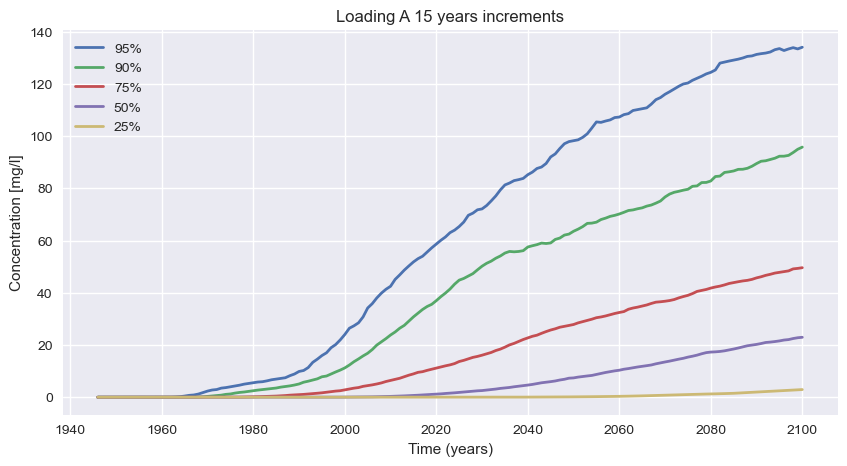

In [19]:
x_time = np.arange(1946,1946+btc_load_A.shape[1])
selected_precentiles = [25, 50, 75, 90, 95]
prc_load_A = plot_percentiles(x_time, btc_load_A, selected_precentiles, "Loading A 15 years increments")

Let's now run the Loading B scenario and plot the results

In [20]:
scenario['loadScen'] = 'Load_B'
btc_load_B, tf = mnts.run_mantis(scenario)

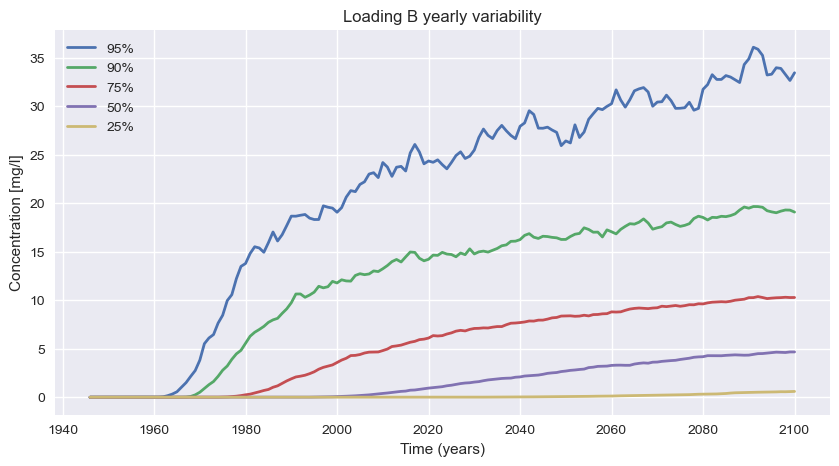

In [21]:
prc_load_B = plot_percentiles(x_time, btc_load_B, selected_precentiles, "Loading B yearly variability")

# Configure Loading Scenarios
So far, we have used the default loading provided with the dataset.

With Mantis Server, it is possible to control the loading by defining which crops to reduce and by how much.

**Uniform Loading Reduction**\
To keep things simple for this example, we will reduce loading uniformly for all crops.\
* Crops are represented as a list of lists:
    * The first element of each inner list is the crop ID.
    * The second element is the reduction factor.
* Crop IDs: Positive numbers represent individual crops; -9 represents all crops.
* * Example: `[-9, 0.5]` reduces loading by 50% for all crops.

In addition to the reduction factor, we must specify the start and end years for the reduction.

The following snippet demonstrates implementing 50% and 100% gradually from 2020 to 2030,
while also extending the simulation period to year 2400:

In [22]:
# Use the loading A scenario again but extend the simulatio to 2400
scenario['loadScen'] = 'Load_A'
scenario['startRed'] = 2030
scenario['endRed'] = 2040
scenario['endSimYear'] = 2400
# Repeat the base loading but for longer
scenario['Crops'] = [[-9, 1.0]]
btc_load_A_0, tf = mnts.run_mantis(scenario)
prc_load_A_0 = np.percentile(btc_load_A_0, axis=0, q=selected_precentiles)
# 50% reduction
scenario['Crops'] = [[-9, 0.5]]
btc_load_A_50, tf = mnts.run_mantis(scenario)
prc_load_A_50 = np.percentile(btc_load_A_50, axis=0, q=selected_precentiles)
# 100% reduction
scenario['Crops'] = [[-9, 0.0]]
btc_load_A_100, tf = mnts.run_mantis(scenario)
prc_load_A_100 = np.percentile(btc_load_A_100, axis=0, q=selected_precentiles)

Plot the percentiles

In [23]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

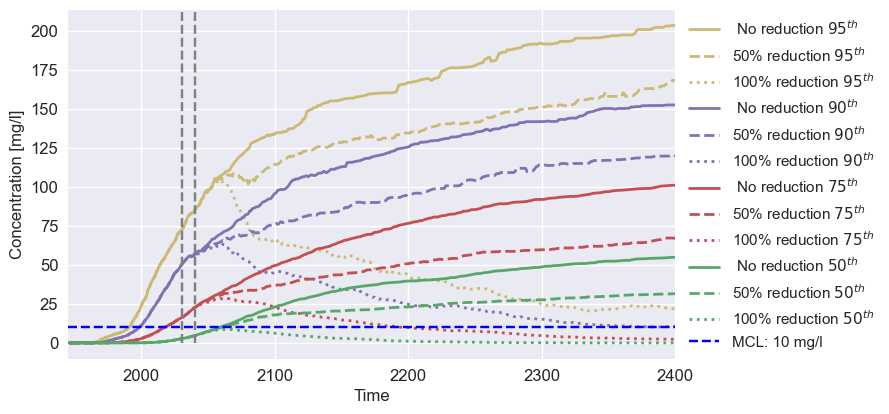

In [24]:
x_time = np.arange(1946,1946+btc_load_A_0.shape[1])
fig, ax = plt.subplots(figsize=(9, 4.3)) #,facecolor='white'
for i in range(len(selected_precentiles) - 1, -1, -1):
    p = selected_precentiles[i]
    if p == 25:
        continue
    ax.plot(x_time, prc_load_A_0[i, :], label=rf" No reduction ${p}^{{th}}$", linewidth=2, color=colors[i])
    ax.plot(x_time, prc_load_A_50[i, :], label=rf"50% reduction ${p}^{{th}}$", linewidth=2, color=colors[i], linestyle='--')
    ax.plot(x_time, prc_load_A_100[i, :], label=rf"100% reduction ${p}^{{th}}$", linewidth=2, color=colors[i], linestyle=':')
ax.set_xlabel('Time',fontsize=12)
ax.set_ylabel('Concentration [mg/l]',fontsize=12)
ax.hlines(y = 10, xmin = 1945, xmax = 2400,linestyles='--', color = 'blue', label = 'MCL: 10 mg/l')
#ax.set_title('Future Loading')
ax.legend(
    loc='center left',          # anchor the legend to the left center of the bounding box
    bbox_to_anchor=(1, 0.5),    # position it outside the axes on the right
    fontsize=11
)
y_lim = ax.get_ylim()
ax.set_xlim([1945, 2400])
ax.set_ylim(y_lim)
ax.grid(True)
ax.vlines(x=2030, ymin=0, ymax=y_lim[1], linestyles='--', color='gray')
ax.vlines(x=2040, ymin=0, ymax=y_lim[1], linestyles='--', color='gray')

ax.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

## Modifying Reduction per Crop

Reducing leaching rates uniformly for all crops is not always realistic.
In this section, we will configure reductions individually for each crop.

### Read Crop Codes and Names. \
Before specifying per-crop reductions, we need to load the crop codes and names.
For this, we will use the Load A dataset. \
We will also set the ending year to 2100

In [25]:
scenario['loadScen'] = 'Load_A'
scenario['endSimYear'] = 2100

In [26]:
crop_codes = pd.read_csv(hydroshare_path + '/TLRData/NO3LOAD/Load_A_CROP_ID.csv')
print(f"Number of crops: {len(crop_codes)}")
crop_codes.head()

Number of crops: 201


,NAME,ID
0,No data,0
1,Urban (backcasted),1
2,Natural Vegetation (backcasted),2
3,Annual Grassland,3
4,Alkali Desert Scrub,4


**Identify the Most Influential Crops**

To determine which crops have the greatest impact on loading in the area, we will perform the following simulations:

Run simulations in a loop:
* For each crop, apply 100% reduction individually while keeping other crops at default levels.
* We do not need to keep the full breakthrough curves (BTCs) for each run.
* Instead, we calculate percentiles and retain values from the last year of the simulation, as these are most representative of long-term impact.

In [27]:
crop_codes_res = crop_codes.copy()
crop_codes_res['conc_50'] = np.nan
crop_codes_res['conc_75'] = np.nan
crop_codes_res['conc_90'] = np.nan
for idx, crop in crop_codes_res.iterrows():
    scenario['Crops'] = [[crop['ID'], 0.0]]
    btc_crop, tf = mnts.run_mantis(scenario)
    prc_crop = np.percentile(btc_crop, axis=0, q=selected_precentiles)
    crop_codes_res.loc[idx, 'conc_50'] = prc_crop[1, -1]
    crop_codes_res.loc[idx, 'conc_75'] = prc_crop[2, -1]
    crop_codes_res.loc[idx, 'conc_90'] = prc_crop[3, -1]

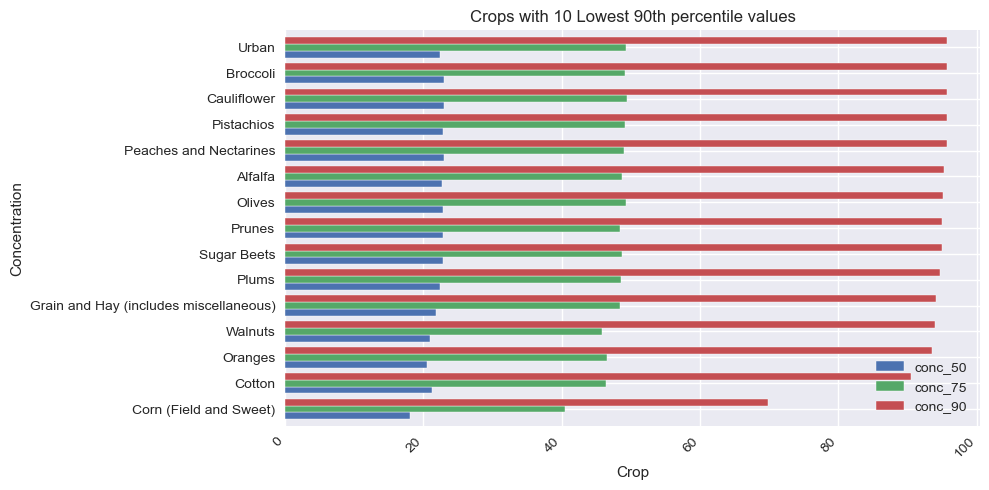

In [28]:
df_plot = crop_codes_res.sort_values(by='conc_90', ascending=True).head(15)
df_plot = df_plot.set_index('NAME')
cols = ['conc_50', 'conc_75', 'conc_90']
ax = df_plot[cols].plot(kind='barh', figsize=(10, 5), width=0.8)
ax.set_ylabel('Concentration')
ax.set_xlabel('Crop')
ax.set_title('Crops with 10 Lowest 90th percentile values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Combine Mantis with Optimization
Since the Mantis Server runs efficiently, we can integrate it with an optimization workflow, as described in the paper.

Our goals are to:
* Minimize economic loss for the area.
* Reduce leaching rates from crops.


For simplicity, we will use crop coverage as a proxy for economic loss.

**Read Crop Coverage and Identify Key Crops**

First, we read the crop coverage data and determine which crop IDs that account for 90% of the total area.

In [29]:
nload = np.loadtxt(hydroshare_path + '/TLRData/NO3LOAD/TLR_Load_A.idxlu', skiprows=1)

Loop through the crop ids and calculate the number of cells

In [30]:
crop_codes_res['cell_count'] = 0
for idx, crop in crop_codes_res.iterrows():
    n_cells =  np.sum(nload[:,-1] == crop['ID'])
    crop_codes_res.loc[idx,'cell_count'] =  np.sum(nload[:,-1] == crop['ID'])
    crop_codes_res.loc[idx,'Area_prc'] =  n_cells/nload.shape[0]

In [31]:
crops_sorted = crop_codes_res.sort_values(by='cell_count', ascending=False)
cumulative_coverage = np.cumsum(crops_sorted['cell_count'])/crops_sorted['cell_count'].sum()
ncrops_90 = np.sum(cumulative_coverage < 0.9)
print(f" Number of crops that cover 90% of the area: {ncrops_90}")

 Number of crops that cover 90% of the area: 15


In [32]:
crops_in_optim = crops_sorted.head(ncrops_90)
crops_in_optim.head(ncrops_90)

,NAME,ID,conc_50,conc_75,conc_90,cell_count,Area_prc
121,Alfalfa,1601,22.68735,48.640225,95.31364,112801,0.135016
193,"Vineyards (includes table grapes, wine grapes,...",2200,20.10595,48.372600,95.76699,98324,0.117687
87,Grain and Hay (includes miscellaneous),700,21.84955,48.372600,94.16307,86237,0.103220
3,Annual Grassland,3,22.95210,49.592725,95.76699,84608,0.101270
82,Corn (Field and Sweet),606,18.09600,40.419475,69.79873,82551,0.098808
59,Oranges,303,20.58770,46.563325,93.45424,77759,0.093072
79,Cotton,601,21.20205,46.445975,90.45998,53942,0.064565
46,Urban,53,22.41220,49.280875,95.67362,36341,0.043498
74,Almonds,412,22.44040,48.691400,95.68851,26567,0.031799
78,"Field Crops (includes Flax, Hops, Castor Beans...",600,22.75735,49.534675,95.76699,21465,0.025692


## Set Up the Objective Function for Optimization

With the key crop IDs identified, we can now define the objective function for the optimization problem.

* Decision Variables \
   The decision variables are the crop reduction rates, defined in the range [0, 1].
   * 0 → full reduction of leaching
   * 1 → no reduction


* Running the Simulation and Calculating Percentiles \
  For each candidate solution x (vector of reduction rates), we:
  * Run the Mantis simulation with the corresponding per-crop reductions.
  * Calculate the percentiles of the resulting loading data.


* Define the Objectives \
  We have two competing objectives:
  * Environmental benefit ($f1$)—Maximize the improvement compared to the baseline:
    $f1=percentiles of baseline−percentiles of optimized scenario$ \
    Since we are minimizing in the optimization routine, we negate $f1$.
  * Economic cost ($f2$)—Minimize the area affected by loading changes:
    * $f2$ is minimum when all x = 1 (no reduction).
    * $f2$ is maximum when all x = 0 (full reduction).
    * We negate $f2$ to treat it as a minimization objective.

Thus, the optimization problem aims to minimize both $-f1$ and $-f2$ simultaneously, representing competing objectives.

In [33]:
def tlr_obj_fnc(x, crop_ids, crop_area, scen, prc_bau, prctiles):
    scenario_local = scen.copy()
    scenario_local['Crops'] = [[crop_id, float(xi)] for crop_id, xi in zip(crop_ids, x)]
    btc_opt, tf = mnts.run_mantis(scenario_local)
    prc_opt = np.percentile(btc_opt, axis=0, q=prctiles)
    f1 = -np.sum(prc_bau - prc_opt[:,-1])
    f2 = -np.sum(x * crop_area)
    return [f1, f2]

## Set Up the Minimization Problem
We will now define the multi-objective minimization problem using pymoo. \
First, we need to import the required modules:

In [34]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

Build the problem class

In [35]:
class TLRProblem(Problem):
    def __init__(self, scen, prc_bau, crop_ids, crop_area, prctiles):
        super().__init__(
            n_var=len(crop_ids),
            n_obj=2,
            n_constr=0,
            xl=np.zeros(len(crop_ids)),
            xu=np.ones(len(crop_ids)),
            type_var=float
         )
        self.scen = scen
        self.prc_bau = prc_bau
        self.crop_ids = crop_ids
        self.crop_area = crop_area
        self.prctiles = prctiles


    def _evaluate(self, X, out, *args, **kwargs):
        F = []
        for x in X:
            F.append(
                tlr_obj_fnc(
                    x,
                    self.crop_ids,
                    self.crop_area,
                    self.scen,
                    self.prc_bau,
                    self.prctiles
                )
            )
        out["F"] = np.array(F)

## Prepare Extra Input Arguments for Optimization
Before running the optimization, we need to prepare additional input arguments for the objective function.

To ensure both objectives are comparable in magnitude, we divide the crop area values by 1e8

In [36]:
crop_ids =np.array(crops_in_optim['ID'])
crop_area = np.array(crops_in_optim['cell_count'])*2500/1e7 # Each pixel is 50x50 meter
prctiles_optm = list(range(10, 100, 10))

## Run the Baseline Scenario
Before starting the optimization, we need to run the baseline scenario. \
To speed up the process, we will limit the simulation period to year 2050, as this provides a representative baseline for comparison.

In [37]:
scenario_opt = scenario.copy()
scenario_opt['loadScen'] = 'Load_A'
scenario_opt['endSimYear'] = 2050
scenario_opt['startRed'] = 2020
scenario_opt['endRed'] = 2025
scenario_opt['unsatWC'] = 0.0
scenario_opt['Crops'] = [[-9, 1.0]]
btc_opt, tf = mnts.run_mantis(scenario_opt)
prc_opt = np.percentile(btc_opt, axis=0, q=prctiles_optm)
prc_bau = prc_opt[:,-1]

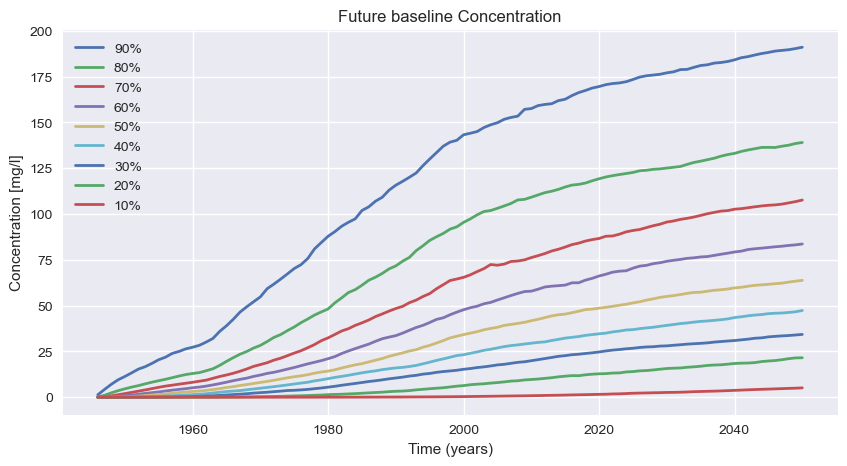

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
for i in range(len(prc_opt) - 1, -1, -1):
    p = prctiles_optm[i]
    ax.plot(np.arange(1946,1946+btc_opt.shape[1]), prc_opt[i, :], label=f"{p}%", linewidth=2)
ax.set_xlabel('Time (years)')
ax.set_ylabel('Concentration [mg/l]')
ax.set_title('Future baseline Concentration')
ax.legend()
plt.show()

Run the optimization. \
The setup of a MOO optimization requires alot of configuration and experimentation, which is beyond the goal of this notebook. \
We will keep everything simple at their default values.

By changing the population size and number of generations the following snippet can be very time consuming. \
For an optimization problem with 15 decision variables we would use population size equal to 100 and let the optimization run for at least 200 generations.\
However here we set `pop_size = 100` and `n_gen = 20`.

In [39]:
problem = TLRProblem(scenario_opt, prc_bau, crop_ids, crop_area, prctiles_optm)
algorithm = NSGA2(pop_size=10,
                  eliminate_duplicates=True)
res = minimize(problem,
               algorithm,
               ('n_gen', 20),
               seed=1,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      6 |             - |             -
     2 |       20 |      8 |  0.0289075398 |             f
     3 |       30 |     10 |  0.2094786200 |         ideal
     4 |       40 |     10 |  0.0205975197 |             f
     5 |       50 |     10 |  0.0454254334 |             f
     6 |       60 |     10 |  0.0126563766 |             f
     7 |       70 |     10 |  0.0299236532 |         ideal
     8 |       80 |     10 |  0.0025821809 |         ideal
     9 |       90 |     10 |  0.0162501939 |             f
    10 |      100 |     10 |  0.0855074000 |         ideal
    11 |      110 |     10 |  0.1466568923 |         ideal
    12 |      120 |     10 |  0.0366086494 |             f
    13 |      130 |     10 |  0.0210010997 |         ideal
    14 |      140 |     10 |  0.0217898119 |             f
    15 |      150 |     10 |  0.0178925063 |             f
    16 |      160 |     10 |  0.0317371385 |            

pymoo provides a quick way to plot the pareto front.

However since we didnt let the optimization run for long in this run the results are suboptimal

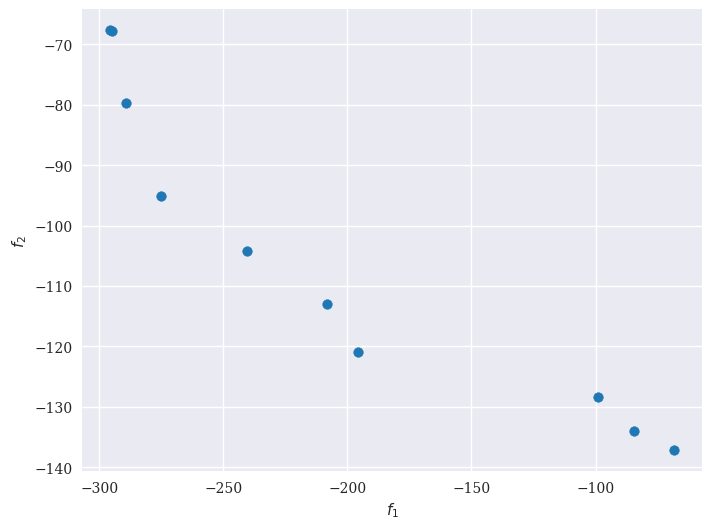

In [43]:
from pymoo.visualization.scatter import Scatter
Scatter().add(res.F).show()

## Save the results
The actual optimization with a population of 100 individuals and 200 generations took about 5 hours. \
So we saved the results of our actual run so that we can retrieve it later.

We will use pickle for that

In [44]:
import pickle

In [ ]:
with open(hydroshare_path + "nsga2_result.pkl", "wb") as f:
    pickle.dump(res, f)

## Load the optimization results

In [49]:
with open(hydroshare_path + "/nsga2_result.pkl", "rb") as f:
    res_loaded = pickle.load(f)

Let's plot the final pareto front.

Before we will sort the values and rename a few crops with very long names so that the plot is prettier

In [50]:
idx = np.argsort(-res_loaded.F[:, 1])[::-1]
X_sorted = res_loaded.X[idx, :]
F_sorted = res_loaded.F[idx, :]
crops_in_optim.iloc[1, crops_in_optim.columns.get_loc('NAME')] = 'Vineyards'
crops_in_optim.iloc[2, crops_in_optim.columns.get_loc('NAME')] = 'Grain and Hay'
crops_in_optim.iloc[4, crops_in_optim.columns.get_loc('NAME')] = 'Corn'
crops_in_optim.iloc[9, crops_in_optim.columns.get_loc('NAME')] = 'Field crops'
crops_in_optim.iloc[11, crops_in_optim.columns.get_loc('NAME')] = 'Idle'

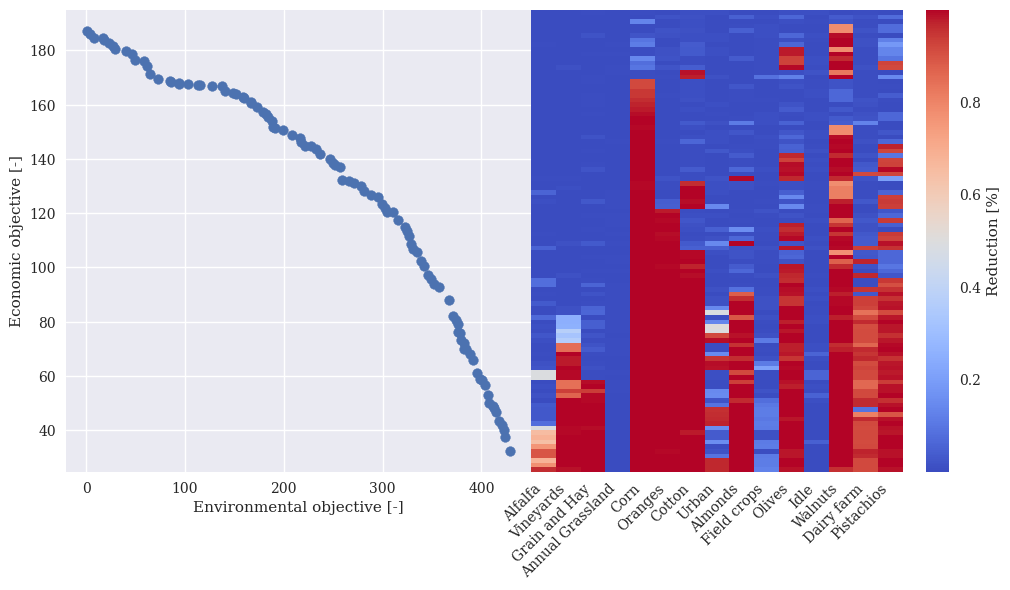

In [51]:
fig, axs = plt.subplots(1,2,figsize=(12,6))
ax = axs[0]
ax.scatter(-res_loaded.F[:,0], -res_loaded.F[:,1])
ax.set_ylabel(r'Economic objective [-]')
ax.set_xlabel(r'Environmental objective [-]')

#fig, ax = plt.subplots(figsize=(5,5))
ax = axs[1]
im = ax.imshow(1-X_sorted, aspect='auto', cmap='coolwarm')
ax.set_xticks(np.arange(len(crop_ids)))
ax.set_xticklabels(crops_in_optim['NAME'], rotation=45, ha='right')
#ax.set_xlabel('Crop')
#ax.set_ylabel(r'Solutions sorted according to economic objective')
ax.set_yticklabels([])
ax.grid(False)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Reduction [%]')

#plt.tight_layout()
plt.subplots_adjust(wspace=0.0, hspace=0.0)
plt.show()